# Ecological Index - NPP validation plots
- Plot CESM data vs. observations
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- July 2025

In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
#import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 
import matplotlib.path as mpath
import dask
import utils
import pandas as pd
import geopandas as gpd
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

### Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [5]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [6]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

## Load NPP data from OBS

In [7]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/validation_data/'

In [8]:
ds_vgpm_mean = xr.open_dataset(path_in+'mean_VGPM_ONDJFM_2003-2020-061725.nc')
ds_cbpm_mean = xr.open_dataset(path_in+'mean_CbPM_ONDJFM_2003-2020-061725.nc')
ds_cafe_mean = xr.open_dataset(path_in+'mean_CAFE_ONDJFM_2003-2018-061725.nc')

In [ ]:
ds_vgpm_mean = ds_vgpm_mean.load()
ds_cbpm_mean = ds_cbpm_mean.load()
ds_cafe_mean = ds_cafe_mean.load()

## Load NPP data from CESM

In [9]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'

In [10]:
# load hindcast data
file_in = 'CESM2-JRA55-hindcast-seasonal-integrals-NPP.nc'
ds_in = xr.open_dataset(path_in+file_in, decode_times=True)

# keep just the full growth season data
npp_hindcast = ds_in.NPP_ONDJFM

In [11]:
# load cesm2-le data
file_in = 'CESM2-LE-seasonal-integrals-NPP.nc'
ds_in = xr.open_dataset(path_in+file_in, decode_times=True)

# keep just the full growth season data
npp_cesm2le = ds_in.NPP_ONDJFM

In [12]:
# trim both datasets to 2003-2020
npp_hindcast = npp_hindcast.isel(time=slice(42,63))
npp_cesm2le  = npp_cesm2le.isel(time=slice(50,71))

In [13]:
# take averages over all years and all ensemble members (for cesm2-le)
npp_hindcast_mean = npp_hindcast.mean(dim=('time'))
npp_cesm2le_mean = npp_cesm2le.mean(dim=('time','member_id'))

In [14]:
# convert these cesm growing season integrals to mean by dividing by the total number of days from Oct 1 to March 31 (182 days)
ndays = 182.0
npp_hindcast_mean = npp_hindcast_mean/ndays
npp_cesm2le_mean = npp_cesm2le_mean/ndays

## Plot figure

In [15]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [16]:
# get colony distance info for plotting
lons = ds_grid.TLONG
lats = ds_grid.TLAT

In [17]:
# mask to omit land points
npp_hindcast_mean = npp_hindcast_mean.where(ds_grid.REGION_MASK == 1)
npp_cesm2le_mean = npp_cesm2le_mean.where(ds_grid.REGION_MASK == 1)

### Set plotting ranges, etc.

In [18]:
# set some plotting info
cmap_in = cmocean.cm.algae
vmin_in = 50.0
vmax_in = 800.0
levels_in_ctr = np.arange(0,3,1)
units = 'mg C m$^{-2}$ d$^{-1}$'

### Get shapefile with geography

In [19]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [20]:
# Read in Antarctic Geography Shapefiles
file_in = 'USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp'

shdf_ant = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ant = shdf_ant.to_crs(ccrs.SouthPolarStereo())

### Save plot

In [21]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_6/'
fout = 'SFigure_NPP_validation'

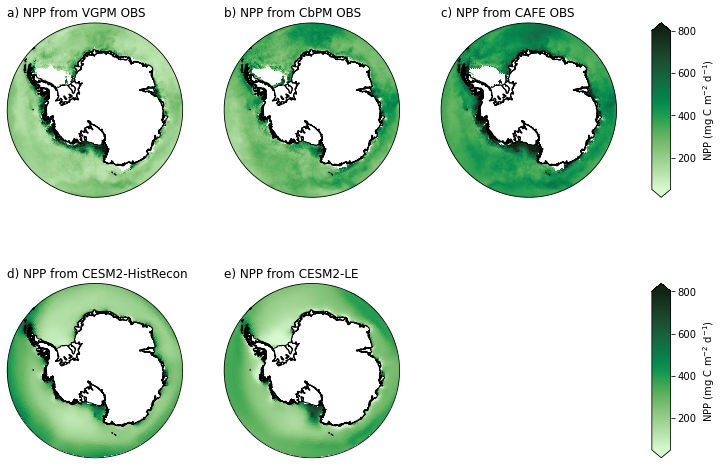

In [25]:
fig = plt.figure(figsize=(12, 8))
#fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(nrows=3, ncols=4, width_ratios=(1, 1, 1, 0.1),height_ratios=(1,0.2,1))
prj =ccrs.SouthPolarStereo()

# set plotting objects
ax_obs1 = plt.subplot(gs[0, 0], projection=prj)
ax_obs2 = plt.subplot(gs[0, 1], projection=prj)
ax_obs3 = plt.subplot(gs[0, 2], projection=prj)
ax_cesm_hind = plt.subplot(gs[2, 0], projection=prj)
ax_cesm2_le = plt.subplot(gs[2, 1], projection=prj)
ax_cb1 = plt.subplot(gs[0, 3])
ax_cb2 = plt.subplot(gs[2, 3])

### Plot Obs #1 ###
ax_obs1.set_boundary(circle, transform=ax_obs1.transAxes)
ax_obs1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax_obs1.set_title('a) NPP from VGPM OBS', loc='left')
pc1=ax_obs1.pcolormesh(ds_vgpm_mean.lon, ds_vgpm_mean.lat,
                     ds_vgpm_mean.NPP,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
# Add shapefile coastlines
ax_obs1.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot Obs #2 ###
ax_obs2.set_boundary(circle, transform=ax_obs2.transAxes)
ax_obs2.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax_obs2.set_title('b) NPP from CbPM OBS', loc='left')
pc1=ax_obs2.pcolormesh(ds_cbpm_mean.lon, ds_cbpm_mean.lat,
                     ds_cbpm_mean.npp,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
# Add shapefile coastlines
ax_obs2.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot Obs #3 ###
ax_obs3.set_boundary(circle, transform=ax_obs3.transAxes)
ax_obs3.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax_obs3.set_title('c) NPP from CAFE OBS', loc='left')
pc1=ax_obs3.pcolormesh(ds_cafe_mean.lon, ds_cafe_mean.lat,
                     ds_cafe_mean.CAFE_NPP_MODIS,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
# Add shapefile coastlines
ax_obs3.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot CESM2 hindcast ###
ax_cesm_hind.set_boundary(circle, transform=ax_cesm_hind.transAxes)
ax_cesm_hind.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax_cesm_hind.set_title('d) NPP from CESM2-HistRecon', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons,lats,npp_hindcast_mean*12.011) #converting from mmol/m2/d to mg/m2/d
pc1=ax_cesm_hind.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
# Add shapefile coastlines
ax_cesm_hind.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot CESM2-LE ###
ax_cesm2_le.set_boundary(circle, transform=ax_cesm2_le.transAxes)
ax_cesm2_le.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax_cesm2_le.set_title('e) NPP from CESM2-LE', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons,lats,npp_cesm2le_mean*12.011) #converting from mmol/m2/d to mg/m2/d
pc1=ax_cesm2_le.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
# Add shapefile coastlines
ax_cesm2_le.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)


### Add color bars ###
cbar1 = fig.colorbar(pc1, cax=ax_cb1, extend='both',label='NPP (mg C m$^{-2}$ d$^{-1}$)')
cbar2 = fig.colorbar(pc1, cax=ax_cb2, extend='both',label='NPP (mg C m$^{-2}$ d$^{-1}$)')


# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)



### Weird spacing

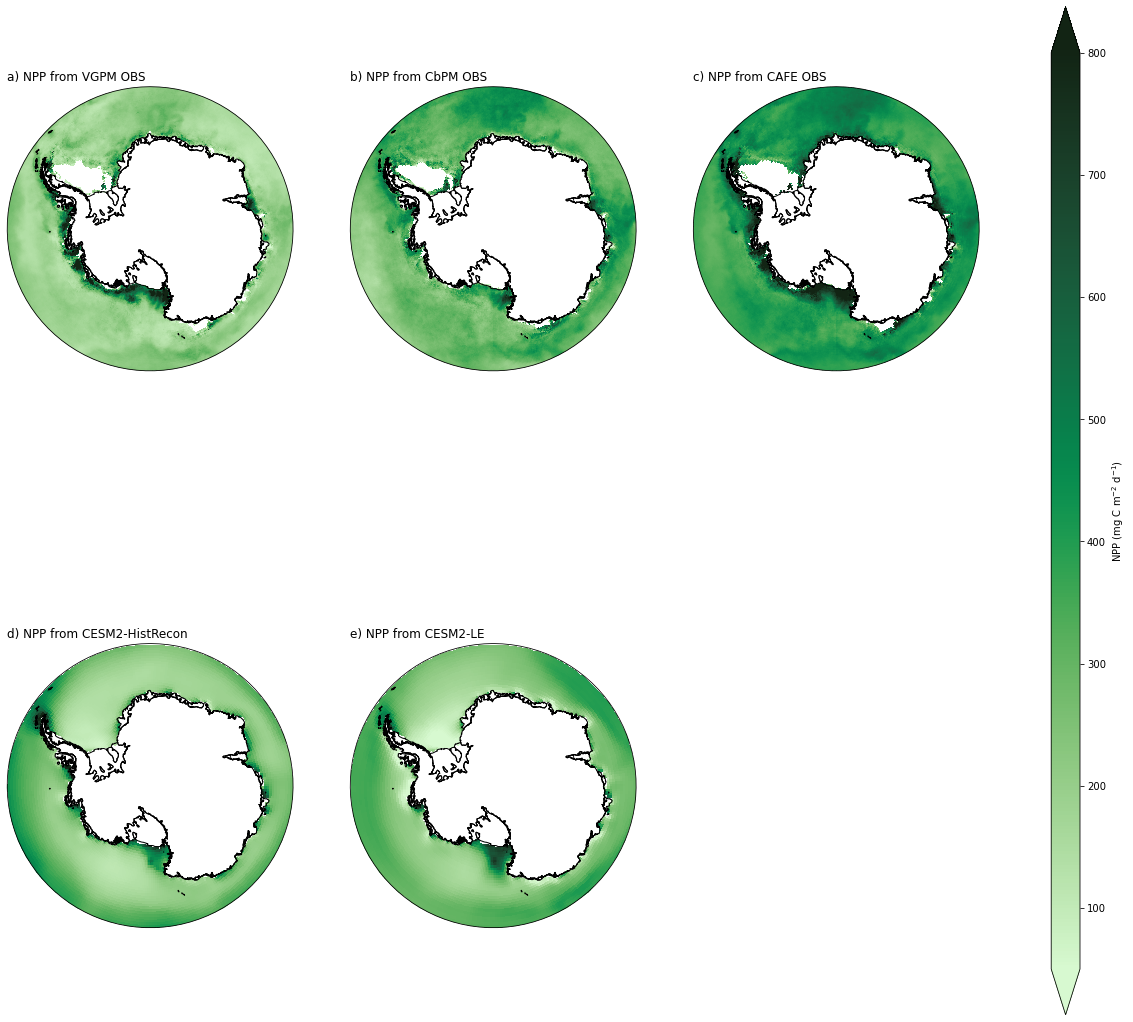

In [22]:
# Plot
# create figure
fig = plt.figure(figsize=(20,20))

# plot the region as subplots - note it's nrow x ncol x index (starting upper left)

### Plot Obs #1 ###
ax = fig.add_subplot(2,3,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('a) NPP from VGPM OBS', loc='left')
this=ax.pcolormesh(ds_vgpm_mean.lon, ds_vgpm_mean.lat,
                     ds_vgpm_mean.NPP,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot Obs #2 ###
ax = fig.add_subplot(2,3,2, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('b) NPP from CbPM OBS', loc='left')
this=ax.pcolormesh(ds_cbpm_mean.lon, ds_cbpm_mean.lat,
                     ds_cbpm_mean.npp,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot Obs #3 ###
ax = fig.add_subplot(2,3,3, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('c) NPP from CAFE OBS', loc='left')
this=ax.pcolormesh(ds_cafe_mean.lon, ds_cafe_mean.lat,
                     ds_cafe_mean.CAFE_NPP_MODIS,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot CESM2 hindcast ###
ax = fig.add_subplot(2,3,4, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('d) NPP from CESM2-HistRecon', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons,lats,npp_hindcast_mean*12.011) #converting from mmol/m2/d to mg/m2/d
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

### Plot CESM2-LE ###
ax = fig.add_subplot(2,3,5, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('e) NPP from CESM2-LE', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons,lats,npp_cesm2le_mean*12.011) #converting from mmol/m2/d to mg/m2/d
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_in,                      
                     vmax=vmax_in, vmin=vmin_in,
                     transform=ccrs.PlateCarree())
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Adjust spacing on the figure
fig.subplots_adjust(right=0.8, hspace=0.05)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(this, cax=cbar_ax,extend='both',label='NPP (mg C m$^{-2}$ d$^{-1}$)')

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)